In [16]:
#import the neccesary packages
import pandas as pd
import numpy as np

#constants
num_classes = 12 # the number of breeds we want to classify
seed = 42 # makes the random numbers in numpy predictable
im_size = 299 # This size of the images
batch_size = 32

#read the csv into a dataframe, group the breeds and 
df = pd.read_csv('labels.csv')
selected_breed_list = list(df.groupby('breed').count().sort_values(by='id', ascending=False).head(num_classes).index)
df = df[df['breed'].isin(selected_breed_list)]
df['filename'] = df.apply(lambda x: ('train/' + x['id'] + '.jpg'), axis=1)


breeds = pd.Series(df['breed'])
print("total number of breeds to classify",len(breeds.unique()))

df.head()

total number of breeds to classify 12


,id,breed,filename
8,003df8b8a8b05244b1d920bb6cf451f9,basenji,train/003df8b8a8b05244b1d920bb6cf451f9.jpg
9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound,train/0042188c895a2f14ef64a918ed9c7b64.jpg
12,00693b8bc2470375cc744a6391d397ec,maltese_dog,train/00693b8bc2470375cc744a6391d397ec.jpg
48,013f8fdf6d638c7bb042f5f17e8a9fdc,tibetan_terrier,train/013f8fdf6d638c7bb042f5f17e8a9fdc.jpg
57,0162b3e0144fb1d1ab82fbff3ace9938,shih-tzu,train/0162b3e0144fb1d1ab82fbff3ace9938.jpg


In [5]:
from keras.preprocessing import image

def read_img(img_id, train_or_test, size):
    """Read and resize image.
    # Arguments
        img_id: string
        train_or_test: string 'train' or 'test'.
        size: resize the original image.
    # Returns
        Image as numpy array.
    """
    path =  train_or_test + "/" + img_id + ".jpg"
    img = image.load_img(path, target_size=size)
    return image.img_to_array(img)

In [6]:
from sklearn.preprocessing import LabelEncoder
label_enc = LabelEncoder()
np.random.seed(seed=seed)
rnd = np.random.random(len(df))
train_idx = rnd < 0.9
valid_idx = rnd >= 0.9
y_train = label_enc.fit_transform(df["breed"].values)
ytr = y_train[train_idx]
yv = y_train[valid_idx]

In [7]:
from tqdm import tqdm
from keras.applications import xception

x_train = np.zeros((train_idx.sum(), im_size, im_size, 3), dtype='float32')
x_valid = np.zeros((valid_idx.sum(), im_size, im_size, 3), dtype='float32')
train_i = 0
valid_i = 0
for i, img_id in tqdm(enumerate(df['id'])):
    img = read_img(img_id, 'train', (im_size, im_size))
    x = xception.preprocess_input(np.expand_dims(img.copy(), axis=0))
    if train_idx[i]:
        x_train[train_i] = x
        train_i += 1
    elif valid_idx[i]:
        x_valid[valid_i] = x
        valid_i += 1
print('Train Images shape: {} size: {:,}'.format(x_train.shape, x_train.size))

1355it [00:09, 147.29it/s]Train Images shape: (1218, 299, 299, 3) size: 326,671,254



In [8]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rotation_range=45,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.25,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

train_generator = train_datagen.flow(x_train, 
                                     ytr, 
                                     batch_size=batch_size)


valid_datagen = ImageDataGenerator()

valid_generator = valid_datagen.flow(x_valid, 
                                     yv, 
                                     batch_size=batch_size)


In [9]:

from keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Model, Input

# create the base pre-trained model
base_model = xception.Xception(weights='imagenet', include_top=False)
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional Xception layers
for layer in base_model.layers:
    layer.trainable = False

# add a global spatial average pooling layer
x = base_model.output
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
# and a logistic layer and set it to the number of breeds we want to classifiy, 
predictions = Dense(num_classes, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

83689472/83683744 [==============================] - 2s 0us/step


In [10]:
import datetime
from keras.callbacks import EarlyStopping, ModelCheckpoint

epochs = 10
learning_rate = 0.001

# checkpoints
early_stopping = EarlyStopping(monitor='val_acc', patience=5)
STAMP = "{}_dog_breed_model".format(datetime.date.today().strftime("%Y-%m-%d"))

bst_model_path = "{}.h5".format(STAMP)
model_checkpoint = ModelCheckpoint(bst_model_path,
                                   save_best_only=True,
                                   save_weights_only=False,
                                  verbose=1)



# compile the model (should be done *after* setting layers to non-trainable)
optimizer = RMSprop(lr=learning_rate, rho=0.9)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])

hist = model.fit_generator(train_generator,
                           steps_per_epoch=train_idx.sum() // batch_size,
                           epochs=epochs, callbacks=[early_stopping, model_checkpoint],
                           validation_data=valid_generator,
                           validation_steps=valid_idx.sum() // batch_size)

# serialize weights to HDF5
model.save(bst_model_path)
print("Saved model to disk")

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
38/38 [==============================] - ETA: 0s - loss: 0.4297 - accuracy: 0.8744WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy

Epoch 00001: val_loss improved from inf to 0.11970, saving model to 2020-07-11_dog_breed_model.h5
38/38 [==============================] - 87s 2s/step - loss: 0.4297 - accuracy: 0.8744 - val_loss: 0.1197 - val_accuracy: 0.9922
Epoch 2/10
38/38 [==============================] - ETA: 0s - loss: 0.2458 - accuracy: 0.9292WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy

Epoch 00002: val_loss improved from 0.11970 to 0.07339, saving model to 2020-07-11_dog_breed_model.h5
38/38 [==============================] - 85s 2s/step - loss: 0.2458 - accuracy: 0.9292 - val_loss: 0.0734 - v

In [12]:
from keras.models import load_model
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os


def predict_from_image(img_path):

    img = image.load_img(img_path, target_size=(299, 299))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]
    
    pred = model.predict(img_tensor)
    sorted_breeds_list = sorted(selected_breed_list)
    predicted_class = sorted_breeds_list[np.argmax(pred)]
    
    plt.imshow(img_tensor[0])                           
    plt.axis('off')
    plt.show()

    return predicted_class

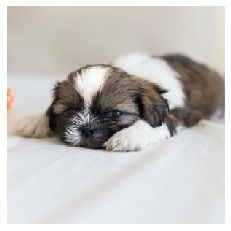

'shih-tzu'

In [21]:
# image path
# !wget http://www.dogbreedslist.info/uploads/allimg/dog-pictures/Scottish-Deerhound-2.jpg
img_path = 'shih-tzu.jpg'    # dog
predict_from_image(img_path)